# Cross-validation showcase

This notebook runs k-fold cross-validation for polynomial regression models trained with gradient descent.
It compares three gradient variants (OLS, Ridge, Lasso) using the RMSprop optimizer and records the
mean MSE and standard deviation for each method. The results are exported to a LaTeX table.



In [8]:
import sys
import os
# Add the project root to sys.path
sys.path.append(os.path.abspath('..'))

from Functions.gradientdescent_lib import *
from Functions.crossvalidation_lib import *
from Functions.bootstrap import bootstrap
import matplotlib.pyplot as plt
import matplotlib as mpl

In [50]:
np.random.seed(1)
x_train, x_test, y_train, y_test = generateData(100, noise = 0.1)
x_train = x_train.flatten(); x_test = x_test.flatten()

learningRate = 0.05
decay = 0.99
n_features = 4
noIntercept = False
n_folds = 10
n_bootstraps = 50

gradient_OLS = Gradients.OLS()
gradient_Ridge = Gradients.Ridge(0.01)
gradient_Lasso = Gradients.Lasso(0.01)

GRADIENTS = [gradient_OLS, gradient_Ridge, gradient_Lasso]

n_features_list = range(0, 16)

results = np.ndarray((len(GRADIENTS), len(n_features_list), 4, 2))


for i, gradient in enumerate(GRADIENTS):
    for j, n_features in enumerate(n_features_list):
        optimizer = Optimizers.RMSprop(learningRate, decay, n_features+int(not noIntercept))
    
        model = GradientDescent(n_features, noIntercept=False)
        model.setOptimizer(optimizer)
        model.setGradient(gradient)
        
        cv_Mean_MSE, cv_MSE_scores, cv_Mean_R2, cv_R2_scores = cross_validation(n_folds, x_train, y_train, model.evaluation_function())
        b_MSE_scores, b_R2_scores, b_bias, b_variance = bootstrap(n_bootstraps, x_train, y_train, x_test, y_test, model.evaluation_function())

        results[i, j, 0] = (cv_Mean_MSE, np.std(cv_MSE_scores))
        results[i, j, 1] = (cv_Mean_R2, np.std(cv_R2_scores))
        results[i, j, 2] = (np.mean(b_MSE_scores), np.std(b_MSE_scores))
        results[i, j, 3] = (np.mean(b_R2_scores), np.std(b_R2_scores))


<Figure size 600x400 with 0 Axes>

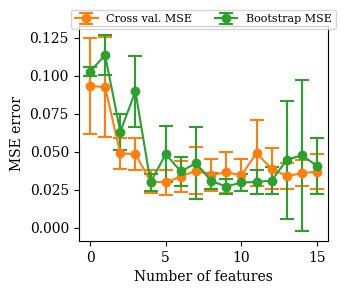

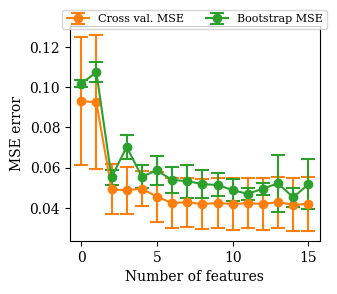

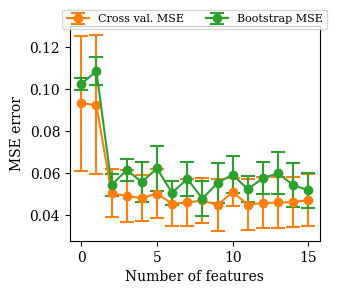

In [66]:
plt.figure(figsize=(6,4))
resultsTransposed = np.transpose(results, (0, 2, 3, 1))

graphNames = ["Cross val. MSE", "Cross val. R2", "Bootstrap MSE", "Bootstrap R2"]

mpl.rcParams.update({
        "font.family": "serif",    # match LaTeX document
        "font.size": 10,           # document font size
        "axes.labelsize": 10,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    })


# Figure size & line width
COLUMNWIDTH_PT = 246.0           # LaTeX \columnwidth
INCHES_PER_PT = 1/72.27
FIG_WIDTH = COLUMNWIDTH_PT * INCHES_PER_PT
FIG_HEIGHT = FIG_WIDTH * 0.6      # adjust aspect ratio
STANDARD_LINEWIDTH = 1.5

color = ['tab:orange', 'tab:blue', 'tab:green', 'tab:red']

for gradient_idx, gradientResult in enumerate(resultsTransposed):

    #plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT*1.5))
    figure, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT*1.5))
    
    for graph_idx, graph in enumerate(gradientResult):
        mean = graph[0]
        std  = graph[1]

        if graph_idx % 2 == 0:
            ax.errorbar(
                n_features_list, mean, yerr=std,
                fmt='-o', capsize=5, elinewidth=1.5, capthick=1.5,
                label=graphNames[graph_idx],
                color=color[graph_idx],
                linewidth=STANDARD_LINEWIDTH
                )
    
    ax.set_xlabel("Number of features")
    ax.set_ylabel("MSE error")

    ax.tick_params(axis='y')


    # Put a single legend for the figure
    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.1),
        ncol=2,
        fontsize=8,
        frameon=True
    )
    plt.tight_layout()
    plt.savefig(f"figures/crossValBootstrap{str(GRADIENTS[gradient_idx])}.pdf", format='pdf')
    plt.show()

<Figure size 600x400 with 0 Axes>

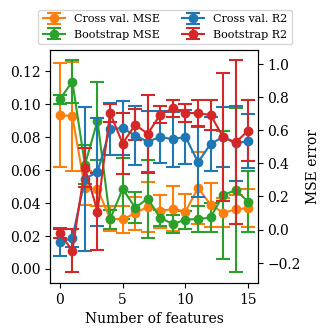

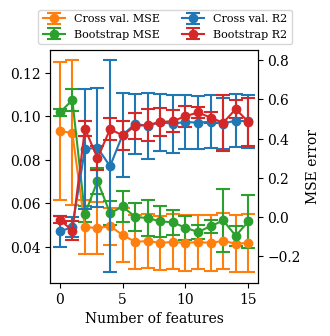

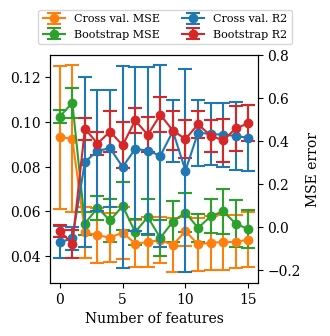

In [ ]:
plt.figure(figsize=(6,4))
resultsTransposed = np.transpose(results, (0, 2, 3, 1))

graphNames = ["Cross val. MSE", "Cross val. R2", "Bootstrap MSE", "Bootstrap R2"]

mpl.rcParams.update({
        "font.family": "serif",    # match LaTeX document
        "font.size": 10,           # document font size
        "axes.labelsize": 10,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    })


# Figure size & line width
COLUMNWIDTH_PT = 246.0           # LaTeX \columnwidth
INCHES_PER_PT = 1/72.27
FIG_WIDTH = COLUMNWIDTH_PT * INCHES_PER_PT
FIG_HEIGHT = FIG_WIDTH * 0.6      # adjust aspect ratio
STANDARD_LINEWIDTH = 1.5

skipR2 = True

color = ['tab:orange', 'tab:blue', 'tab:green', 'tab:red']

for gradient_idx, gradientResult in enumerate(resultsTransposed):

    #plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT*1.5))
    fig, ax1 = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT*1.5))
    ax2 = ax1.twinx()
    
    for graph_idx, graph in enumerate(gradientResult):
        mean = graph[0]
        std  = graph[1]

        if graph_idx % 2 == 0:
            ax1.errorbar(
                n_features_list, mean, yerr=std,
                fmt='-o', capsize=5, elinewidth=1.5, capthick=1.5,
                label=graphNames[graph_idx],
                color=color[graph_idx],
                linewidth=STANDARD_LINEWIDTH
            )
        else:
            ax2.errorbar(
                n_features_list, mean, yerr=std,
                fmt='-o', capsize=5, elinewidth=1.5, capthick=1.5,
                label=graphNames[graph_idx],
                color=color[graph_idx],
                linewidth=STANDARD_LINEWIDTH
            )
    
    ax1.set_xlabel("Number of features")
    ax1.set_ylabel("R² error")
    ax2.set_ylabel("MSE error")

    ax1.tick_params(axis='y')
    ax2.tick_params(axis='y')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    # Combine
    all_lines = lines1 + lines2
    all_labels = labels1 + labels2

    # Put a single legend for the figure
    fig.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.1),
        ncol=2,
        fontsize=8,
        frameon=True
    )
    plt.tight_layout()
    plt.savefig(f"figures/crossValBootstrap{str(GRADIENTS[gradient_idx])}.pdf", format='pdf')
    plt.show()